In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from labellines import labelLines


os.environ["QT_QPA_PLATFORM"] = "xcb"
plt.rcParams["axes.unicode_minus"] = False

plt.rcParams["axes.labelsize"] = 18
plt.rcParams["axes.titlesize"] = 18

In [2]:
## Specify parameters for the model.
# Specify concentration as a function of location for constant and linear cases.
linear_conc_grad = 1
# Specify location intercal and time interval.
location_interval = 1
time_interval = 1
# Specity velocty.
velocity = 1
# Specity constants related to tumbling probability/
tau_s = 2
A_max = 1
A_min = 0.1
k = 2.231

# 1D location bins.
locations = np.arange(-500, 500, location_interval)
# 1D time bins. Each step is 1 ms
times = np.arange(0, 1000, time_interval)

In [3]:
## Utility functions
def simulate_run(x0, s0, tau_s, A_min, conc_type):
    """Simulate the chemotaxis process. The concentration gradient is either flat (same everywhere) or linear (0 at x=0 and increases to the right.)

    :param x0: initial x (position) value.
    :type x0: float.
    :param s0: initial s value.
    :type s0: float.
    :param tau_s: constant used in s dynamics equation.
    :type tau_s: float.
    :param A_min: constant used in s dynamics equation.
    :type A_min: float.
    :param conc_type: type of concentration landscape of attractant.
    :type conc_type: string.
    :return: simulation results.
    :rtype: np array.
    """
    simulation_results = np.zeros(len(times))
    simulation_results[0] = x0
    s = np.zeros(len(times))
    s[0] = s0
    # Iterate through the time steps
    for i in range(1, len(times)):
        ## Get s first.
        # Get the last displacement. Set the first step to be moving to the right.
        if i == 1:
            # Randomly set the last displacement
            if np.random.random() < 0.5:
                last_displacement = -velocity
            else:
                last_displacement = velocity
        else:
            last_displacement = simulation_results[i - 1] - simulation_results[i - 2]
        if conc_type == "flat":
            delta_c = 0
        else:
            # If moving to the right, then c(t-1) - c(t) < 0.
            if last_displacement > 0:
                delta_c = -linear_conc_grad
            else:
                delta_c = linear_conc_grad
        # Forward euler for s
        s[i] = s[i - 1] + ((-s[i - 1] + delta_c) / tau_s) * time_interval

        # Get probability of tumbling.
        p_tumble = (A_max - A_min) / (1 + np.exp(k * s[i])) + A_min
        if p_tumble > 1:
            print("invalid value of p_tumble when tau, s are", tau_s, A_min)
        # decide whether to tumble with probability p_tumble.
        if np.random.random() < p_tumble:
            simulation_results[i] = simulation_results[i - 1] + last_displacement
        else:
            simulation_results[i] = simulation_results[i - 1] - last_displacement

    return simulation_results


def plot_trajectory(simulation_results):
    """Plot the resulting tragectories.

    :param simulation_results: simulated location results.
    :type simulation_results: np array.
    """
    plt.plot(times, simulation_results)
    plt.xlabel("time")
    plt.ylabel("position")
    plt.show()


def plot_trajectory_samples(simulation_results_list, flat):
    """Plot a series of resulting tragectories.

    :param simulation_results_list: simulated location results.
    :type simulation_results_list: list of np arrays.
    :param flat: whether in flat regime.
    :type flat: boolean.
    """
    for simulation_result in simulation_results_list:
        plt.plot(times, simulation_result)
    plt.xlabel("time")
    plt.ylabel("position")
    if flat:
        plt.title("Flat")
        plt.savefig("1_flat.png")
    else:
        plt.title("Linear")
        plt.savefig("1_linear.png")
    plt.show()


def plot_trajectory_multiple(simulation_results_list, labels, flat, tau):
    """Plot a series of resulting tragectories.

    :param simulation_results_list: simulated location results.
    :type simulation_results_list: list of np arrays.
    :param labels: labels for different traces.
    :type labels: list of strings.
    :param flat: whether in the flat regime.
    :type flat: boolean.
    :param tau: whether varying tau.
    :type tau: boolean.
    """
    for simulation_results, label in zip(simulation_results_list, labels):
        plt.plot(times, simulation_results, label=label)
    plt.xlabel("time")
    plt.ylabel("position")
    plt.legend()
    # labelLines(plt.gca().get_lines(), zorder=2.5)
    if flat:
        plt.title("Flat")
    else:
        plt.title("Linear")
    if tau:
        if flat:
            plt.savefig("2_flat_tau.png")
        else:
            plt.savefig("2_linear_tau.png")
    else:
        if flat:
            plt.savefig("2_flat_A_min.png")
        else:
            plt.savefig("2_linear_A_min.png")
    plt.show()

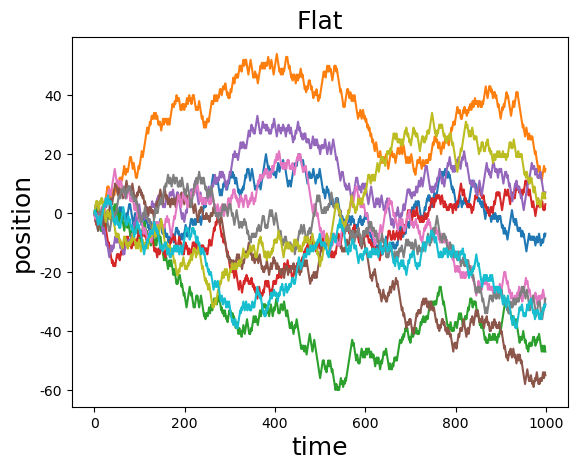

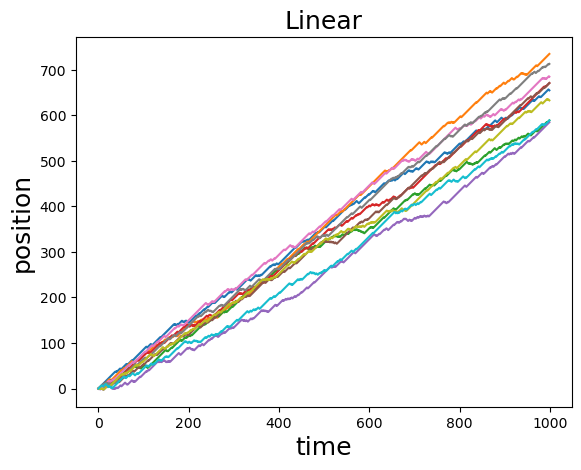

In [4]:
simulation_results = simulate_run(0, 0.1, tau_s, A_min, "linear")
num_examples = 10

simulation_results_flat = []
simulation_results_linear = []
for i in range(num_examples):
    simulation_results_flat.append(simulate_run(0, 0.1, tau_s, A_min, "flat"))
    simulation_results_linear.append(simulate_run(0, 0.1, tau_s, A_min, "linear"))

plot_trajectory_samples(simulation_results_flat, True)
plot_trajectory_samples(simulation_results_linear, False)

/tmp/ipykernel_5215/2128169735.py:46: RuntimeWarning: overflow encountered in exp
  p_tumble = (A_max - A_min) / (1 + np.exp(k * s[i])) + A_min
/tmp/ipykernel_5215/2128169735.py:43: RuntimeWarning: overflow encountered in scalar divide
  s[i] = s[i - 1] + ((-s[i - 1] + delta_c) / tau_s) * time_interval
/tmp/ipykernel_5215/2128169735.py:43: RuntimeWarning: invalid value encountered in scalar add
  s[i] = s[i - 1] + ((-s[i - 1] + delta_c) / tau_s) * time_interval
/tmp/ipykernel_5215/2128169735.py:46: RuntimeWarning: overflow encountered in scalar multiply
  p_tumble = (A_max - A_min) / (1 + np.exp(k * s[i])) + A_min


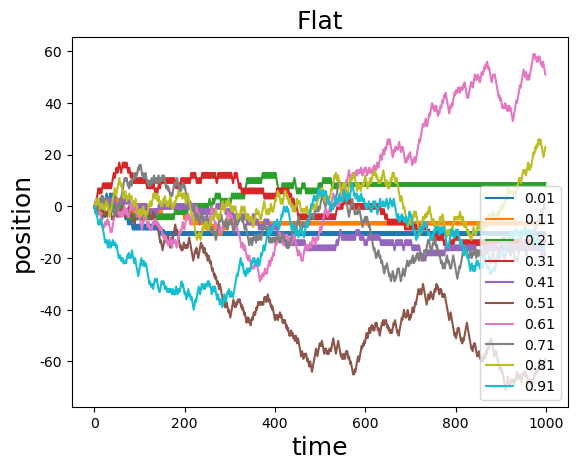

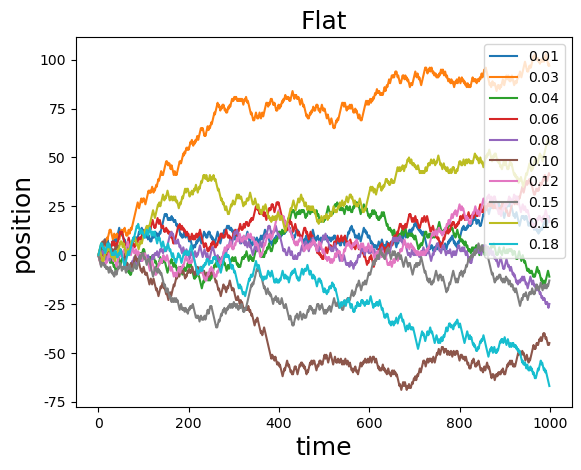

In [5]:
## Q2: Explore how trajectories depend on tau_s and A_min in (1) flat concentration and (2) linear concentration

# Case (1): flat, vary tau_s
tau_s_array = np.arange(0.01, 1, 0.1)
tau_s_label_array = [i[:4] for i in tau_s_array.astype("U")]
simulation_results_tau_s = []
for tau_s_value in tau_s_array:
    simulation_results_tau_s.append(simulate_run(0, 0.1, tau_s_value, A_min, "flat"))

plot_trajectory_multiple(
    simulation_results_tau_s,
    tau_s_label_array,
    flat=True,
    tau=True,
)

# Case (2): flat, vary A_min
A_min_array = np.arange(0.01, 0.2, 0.02)
A_min_label_array = [i[:4] for i in A_min_array.astype("U")]
simulation_results_A_min = []
for A_min_value in A_min_array:
    simulation_results_A_min.append(simulate_run(0, 0.1, 2, A_min_value, "flat"))
plot_trajectory_multiple(
    simulation_results_A_min,
    A_min_label_array,
    flat=True,
    tau=False,
)

/tmp/ipykernel_5215/2128169735.py:46: RuntimeWarning: overflow encountered in exp
  p_tumble = (A_max - A_min) / (1 + np.exp(k * s[i])) + A_min
/tmp/ipykernel_5215/2128169735.py:43: RuntimeWarning: overflow encountered in scalar divide
  s[i] = s[i - 1] + ((-s[i - 1] + delta_c) / tau_s) * time_interval
/tmp/ipykernel_5215/2128169735.py:43: RuntimeWarning: invalid value encountered in scalar add
  s[i] = s[i - 1] + ((-s[i - 1] + delta_c) / tau_s) * time_interval
/tmp/ipykernel_5215/2128169735.py:46: RuntimeWarning: overflow encountered in scalar multiply
  p_tumble = (A_max - A_min) / (1 + np.exp(k * s[i])) + A_min


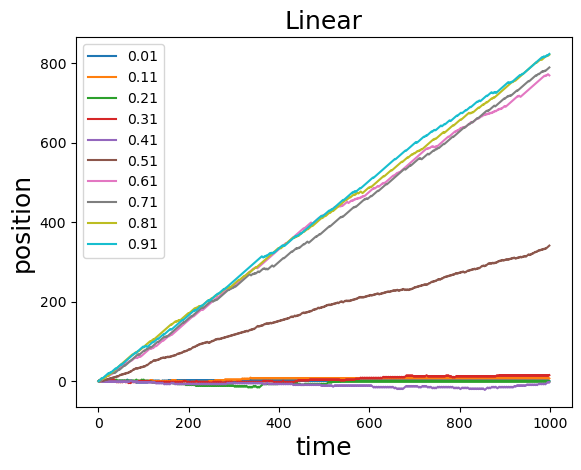

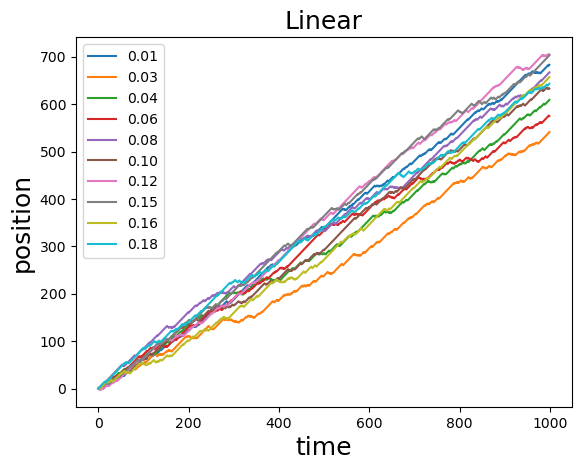

In [6]:
# Case (3): linear, vary tau_s
simulation_results_tau_s = []
for tau_s_value in tau_s_array:
    simulation_results_tau_s.append(simulate_run(0, 0.1, tau_s_value, A_min, "linear"))

plot_trajectory_multiple(
    simulation_results_tau_s,
    tau_s_label_array,
    flat=False,
    tau=True,
)

# Case (4): linear, vary A_min
simulation_results_A_min = []
for A_min_value in A_min_array:
    simulation_results_A_min.append(simulate_run(0, 0.1, 2, A_min_value, "linear"))
plot_trajectory_multiple(
    simulation_results_A_min,
    A_min_label_array,
    flat=False,
    tau=False,
)

Slope of line is  6.247756370677831e-05
r squared is -0.02969097286066802


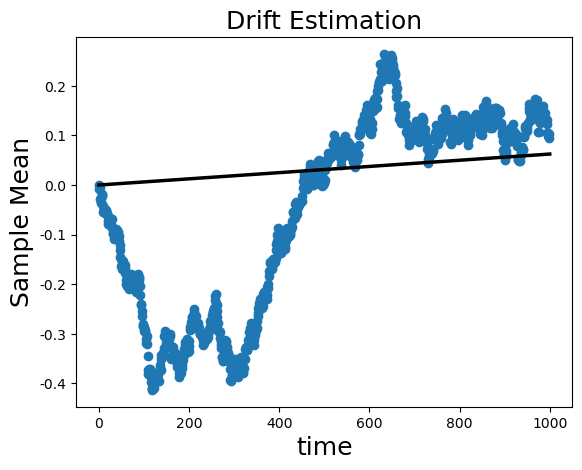

Slope of line is  1.2159895622513954
r squared is 0.999720359596559


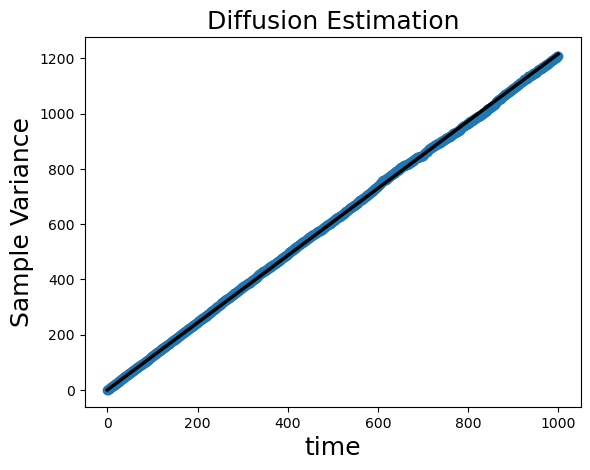

In [15]:
## Q3: estimate drift and diffusion constants for (1) flat and (2) linear gradients
from statistics import linear_regression


def fit_to_linear_regression(data, flat, v):
    """Plot graph and fit a linear regression model to it.

    :param data: data to be fitted.
    :type data: np array.
    :param flat: whether in flat regime.
    :type flat: boolean.
    :param v: whether plot for drift.
    :type v: boolean.
    """
    # Add scatterplot
    plt.scatter(times, data)

    # Fit linear regression via least squares with linear_regression
    # It returns an slope (b) and intercept (a)
    b, a = linear_regression(times, data, proportional=True)
    print("Slope of line is ", b)

    # Create sequence of numbers from 0 to time.
    xseq = np.linspace(0, len(times), num=len(times))
    predicted = a + b * xseq
    print("r squared is", r2_score(data, predicted))

    # Plot regression line
    plt.plot(xseq, predicted, color="k", lw=2.5)
    plt.xlabel("time")
    if flat:
        if v:
            plt.title("Drift Estimation")
            plt.ylabel("Sample Mean")
            plt.savefig("3_flat_v.png")
        else:
            plt.title("Diffusion Estimation")
            plt.ylabel("Sample Variance")
            plt.savefig("3_flat_D.png")
    else:
        if v:
            plt.title("Drift Estimation")
            plt.ylabel("Sample Mean")
            plt.savefig("3_linear_v.png")
        else:
            plt.title("Diffusion Estimation")
            plt.ylabel("Sample Variance")
            plt.savefig("3_linear_D.png")
    plt.show()


num_runs = 10000

# Case (1): flat
# Generate a lot of simulation traces.
simulation_results_flat = np.zeros((num_runs, len(times)))
for i in range(num_runs):
    simulation_results_flat[i, :] = simulate_run(0, 0.1, tau_s, A_min, "flat")

# Mean of x = v t; variance of x = 2 D t
sample_mean_of_location = simulation_results_flat.mean(axis=0)
sample_variance_of_location = simulation_results_flat.var(axis=0)


fit_to_linear_regression(sample_mean_of_location, flat=True, v=True)
fit_to_linear_regression(
    sample_variance_of_location,
    flat=True,
    v=False,
)

Slope of line is  0.6494789279252239
r squared is 0.9999922513930393


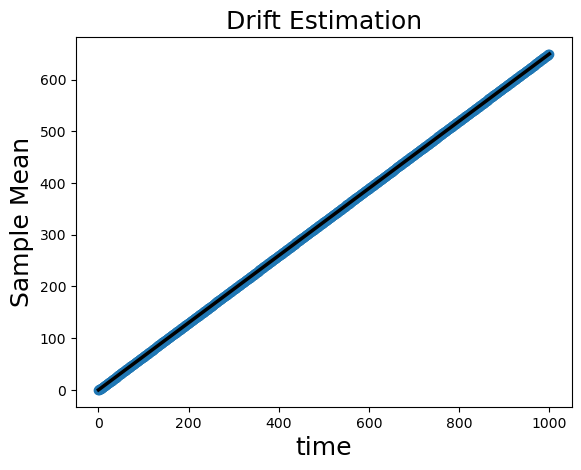

Slope of line is  1.4996899570595914
r squared is 0.9998923733985852


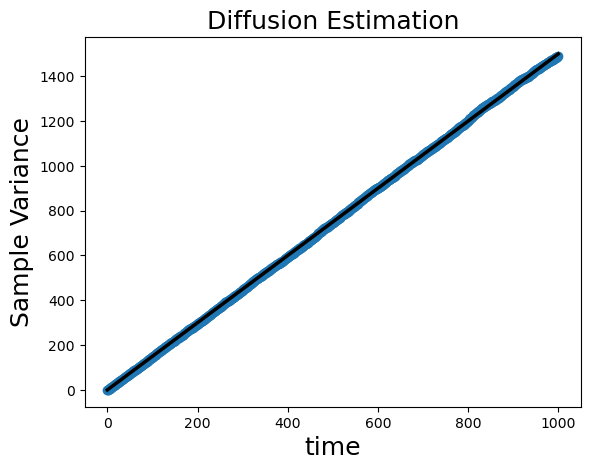

In [16]:
# Case (2): linear
# Generate a lot of simulation traces.
simulation_results_flat = np.zeros((num_runs, len(times)))
for i in range(num_runs):
    simulation_results_flat[i, :] = simulate_run(0, 0.1, tau_s, A_min, "linear")

# Mean of x = v t; variance of x = 2 D t
sample_mean_of_location = simulation_results_flat.mean(axis=0)
sample_variance_of_location = simulation_results_flat.var(axis=0)


fit_to_linear_regression(sample_mean_of_location, flat=False, v=True)
fit_to_linear_regression(
    sample_variance_of_location,
    flat=False,
    v=False,
)

In [9]:
# # UNUSED:
# # Calculate p(x, t) for all x and t, normalise along x and t dimensions.
# def get_probability_distribution(simulation_results):
#     """Get the probability distribution matrix for the simulation runs.

#     :param simulation_results: results of all simulation runs.
#     :type simulation_results: list of arrays.
#     :return: normalised distribution matrix.
#     :rtype: np array.
#     """
#     # Intialise distribution matrix, with time being rows and positions being columns.
#     p_distribution_matrix = np.zeros((len(locations), len(times)))
#     # Iterate through each run/
#     for i in range(num_runs):
#         individual_run = simulation_results[i]
#         # iterate through each time bin.
#         for j in range(len(times)):
#             # Identify to which bin the location x belongs to in the locations lattice.
#             bin = np.digitize([individual_run[j]], locations)[0]
#             p_distribution_matrix[bin, j] += 1

#     # Normalise such that each row sums to one.
#     row_sums = p_distribution_matrix.sum(axis=1)
#     normalised_p_distribution_matrix = p_distribution_matrix / row_sums[:, np.newaxis]
#     return normalised_p_distribution_matrix

# normalised_p_distribution_matrix = get_probability_distribution(simulation_results_flat)

# Calculate key quantities such as dp/dt, d2p/dx2 and dp/dx
# def get_derivative_quantities(normalised_p_distribution_matrix):
#     """Get the derivatives from the normalised probability distribution matrix.

#     :param normalised_p_distribution_matrix: normalised probability distribution of molecules.
#     :type normalised_p_distribution_matrix: np array.
#     :return: dp_dt_array, dp_dx_array, d2p_dx2_array
#     :rtype: numpy arrays
#     """
#     num_time_steps = normalised_p_distribution_matrix.shape[1]
#     num_locations = normalised_p_distribution_matrix.shape[0]

#     ## Calculate dp/dt
#     # one less column since we are calculating the time difference here.
#     dp_dt_array = np.zeros((num_locations, num_time_steps - 1))
#     for i in range(num_locations):
#         for j in range(num_time_steps - 1):
#             # dp/dt = (p(t + 1) - p(t))/ delta_t
#             dp_dt_array[i, j] = (
#                 normalised_p_distribution_matrix[i, j + 1]
#                 - normalised_p_distribution_matrix[i, j]
#             )

#     # Normalise by dividing by the time interval.
#     dp_dt_array = dp_dt_array / time_interval

#     ## Calculate dp/dx
#     # one less column since we are calculating the location difference here.
#     dp_dx_array = np.zeros((num_locations - 1, num_time_steps))
#     for i in range(num_locations - 1):
#         for j in range(num_time_steps):
#             # dp/dx = (p(x + 1) - p(x))/ delta_x
#             dp_dx_array[i, j] = (
#                 normalised_p_distribution_matrix[i + 1, j]
#                 - normalised_p_distribution_matrix[i, j]
#             )
#     # Normalise by dividing by the location interval.
#     dp_dx_array = dp_dx_array / location_interval

#     ## Calculate d2p/dx2
#     # two less columns since we are calculating the location difference here.
#     d2p_dx2_array = np.zeros((num_locations - 2, num_time_steps))
#     for i in range(num_locations - 2):
#         for j in range(num_time_steps):
#             # dp/dx = (dp(x + 1)/dx - dp(x)/dx)/ delta_x
#             d2p_dx2_array[i, j] = dp_dx_array[i + 1, j] - dp_dx_array[i, j]
#     # Normalise by dividing by the location interval.
#     d2p_dx2_array = d2p_dx2_array / location_interval

#     return dp_dt_array, dp_dx_array, d2p_dx2_array


# dp_dt_array, dp_dx_array, d2p_dx2_array = get_derivative_quantities(normalised_p_distribution_matrix)